# LoRA

Low Rank 低秩，本质是将一个大的矩阵分解成两个小的矩阵相乘，以此减少存储的参数，加速运算

在Transformer中，lora是可以直接和FFN层对其的：即不修改FFN层参数，增加一个lora权重层，只需要训练这个lora权重层，最后FFN层权重和lora层权重相加

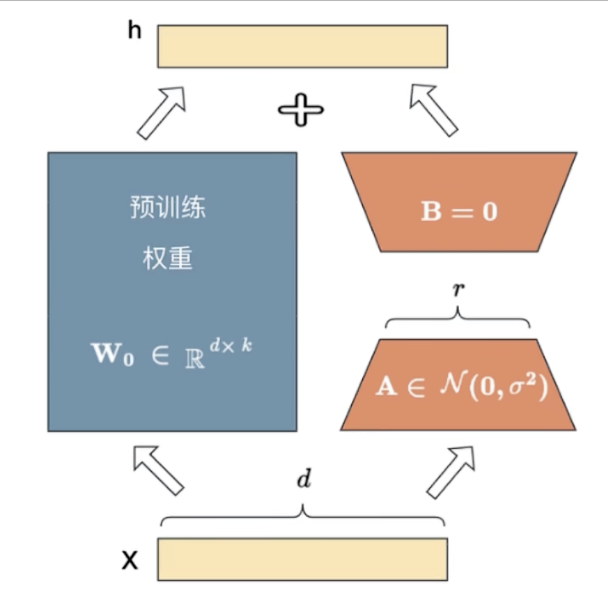

LoRA：这里的架构图右侧的两个矩阵A和B就是两个低秩矩阵，A：（rank,in_features）B:(out_features,rank)

相乘结果为：(out_features,in_features)

x的大小为（batch_size，in_features），计算步骤为：B * x * A^t ，一般先计算x*A^t，这样就分为了两步，两个小矩阵和x的运算

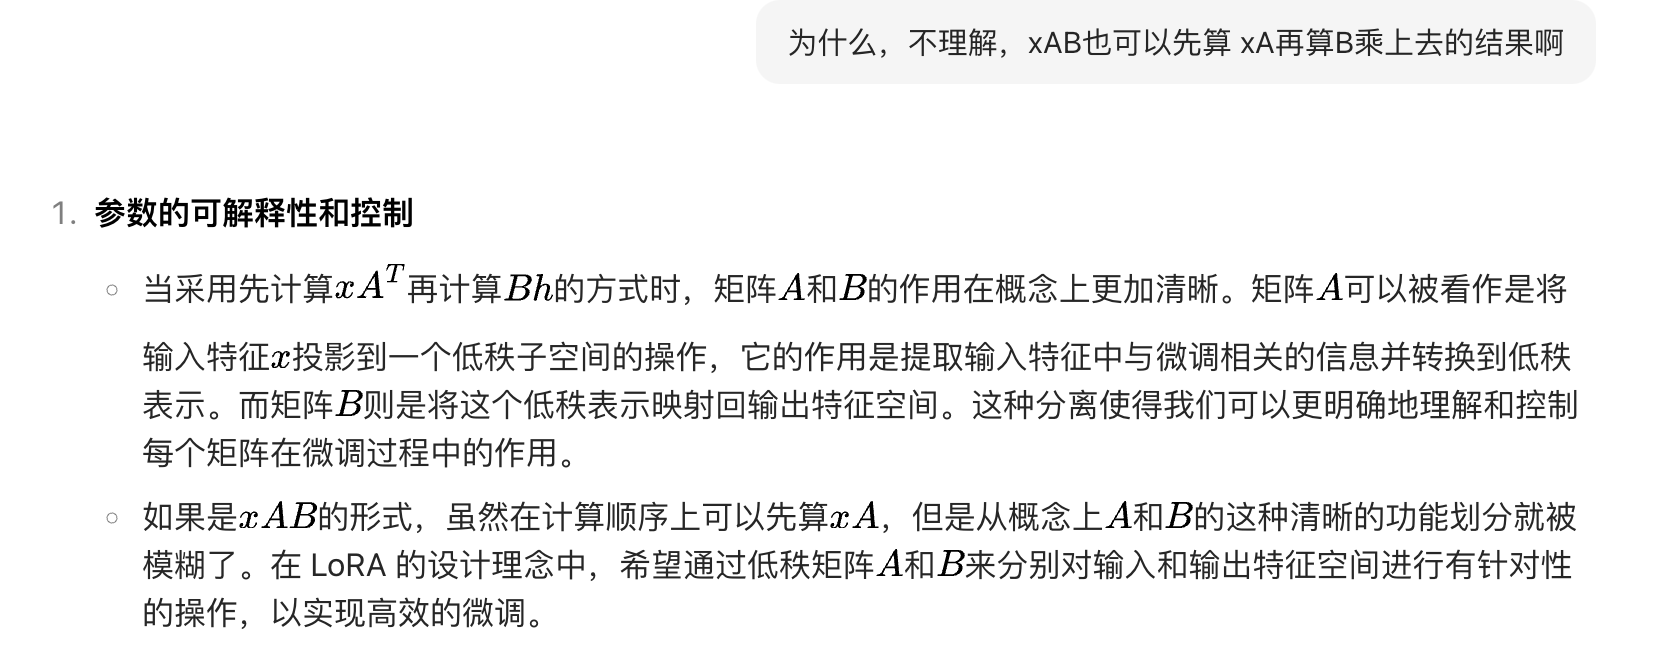
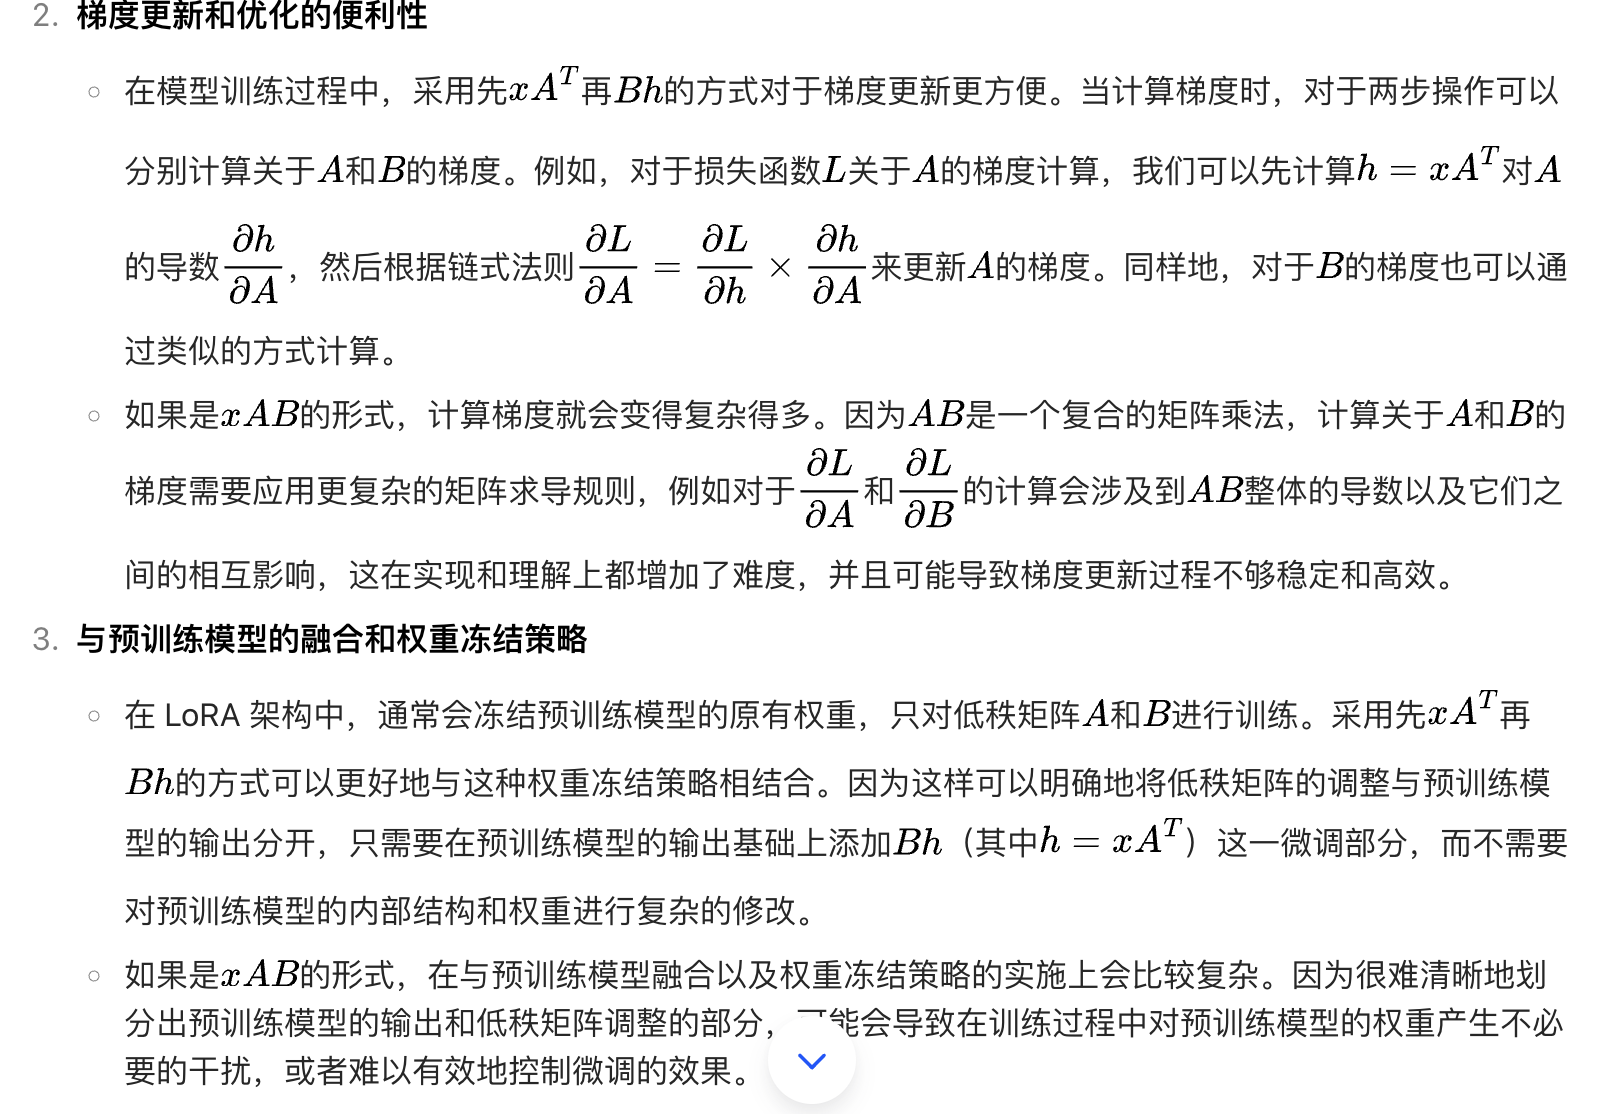

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


In [14]:
class LoRALinear(nn.Module):
    # merge:是否将预训练的FFN层加上
    # rank：降低的维度
    # lora_alpha 和预训练的权重相加的时候比例是怎么样的
    def __init__(self,in_features,out_features,merge,rank=16,lora_alpha=16,dropout=0.5):
        super(LoRALinear,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.merge = merge
        self.rank = rank
        self.lora_alpha = lora_alpha
        self.dropout_rate = dropout

        # 这个linear是预训练模型中的FFN层
        self.linear = nn.Linear(in_features,out_features)
        # 按照架构图构造
        if rank>0:
            self.lora_b = nn.Parameter(torch.zeros(out_features,rank))
            self.lora_a = nn.Parameter(torch.zeros(rank,in_features))
            # 以一个权重系数放缩加到预训练模型的FFN层结果
            # 避免和模型的FFN权重差值过大
            self.scale = self.lora_alpha/self.rank
            # 模型的线性层不计算梯度，不更新
            self.linear.weight.requires_grad=False
        # dropout设置
        if self.dropout_rate>0:
            self.dropout = nn.Dropout(self.dropout_rate)
        # 初始化LoRA的参数
        self.initial_weights()


    def initial_weights(self):
        # 初始化一个均匀分布的数值，按照图上应该用kaiming_normal_正态分布，这里是和up主一致
        nn.init.kaiming_normal_(self.lora_a,a = math.sqrt(5))
        nn.init.zeros_(self.lora_b)
    
    def forward(self,x):
        # 需要低秩且需要合并ffn结果的情况
        if self.rank>0 and self.merge:
            # 手动调用线性层，提供x，w，b，自动执行 w@x + b
            # 可以在这里打断点查看shape，linear.weight的shape也是out_features,in_features
            output = F.linear(x,self.linear.weight + self.lora_b @ self.lora_a * self.scale,self.linear.bias)
            output = self.dropout(output)
            return output
        else:
            return self.dropout(self.linear(x))



In [15]:
# 假设transformer块的attention层输出是批次8，维度32
attention_output = torch.normal(mean=0,std=1,size=(8,32))
# 一般ffn层不改变维度
lora = LoRALinear(32,32,1)
res = lora(attention_output)

In [17]:
res.shape

torch.Size([8, 32])

# LoRA和llm的结合

以peft库实现为例子

注册 LoRA 层的 hook 函数
在`peft/src/peft/tuners/lora/__init__.py`中的inject_adapter函数实现了向模型中注入LoRA层的功能，关键代码如下：

可以看到只对linear层修改（其实就是ffn），不改其他模块

初始化lora的weight为ffn的weight，lora保存两个weight，一个是ffn的weight，一个是自己的weight，每次计算的时候使用的`weight：ffn的weight+scaling x lora_A x lora_B的结果`

然后调用setattr，替换ffn层为lora层

In [ ]:
def inject_adapter(model, peft_config):
   ...
    for name, module in model.named_modules():
        if isinstance(module, peft_config.base_layer_class):
            if any(re.fullmatch(pattern, name) for pattern in target_module_patterns):
                if isinstance(module, torch.nn.Linear):
                    lora_layer = Linear8bitLt if is_bnb_available() and isinstance(module, Linear8bitLt) else Linear
                    lora_layer = lora_layer(
                        in_features=module.in_features,
                        out_features=module.out_features,
                        r=peft_config.r,
                        lora_alpha=peft_config.lora_alpha,
                        lora_dropout=peft_config.lora_dropout,
                        fan_in_fan_out=peft_config.fan_in_fan_out,
                        bias=peft_config.bias,
                    )
                    lora_layer.weight = module.weight
                    lora_layer.to(module.weight.device)
                    setattr(model, name, lora_layer)  # 执行替换
                    module.register_forward_hook(lora_layer._forward_hook)